- this one's not working very well:
    - due to the expansion to (32,32) and the flipping and rotation, the model predicts all black --> most of the screen is indeed black
    - without rotation most of the action is concentrated in the upper left corner
    
- NEXT STEPS: 
    - augmentation only to the original size
    - expanding each pair of each set in the tasks
    - loop in a loop in a loop
    
    
`this notebook DOES have some visuals at the bottom`

NEW NEW NEW
- new color definition

In [1]:
import numpy as np
import pandas as pd
import random 
from random import randint

import os
import json
from pathlib import Path

import tensorflow.keras as keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
data_path = Path('./kaggle_input/')
training_path = data_path / 'training'      # 400 X-train ('train'), y-train('test') input-output pairs
evaluation_path = data_path / 'evaluation'  # 400
test_path = data_path / 'test'              # 100 pairs X-train ('train') (input-output),
                                            #           y-train (input only) pairs

training_tasks_files = sorted(os.listdir(training_path))#[1:]
eval_tasks_files = sorted(os.listdir(evaluation_path))
test_task_files = sorted(os.listdir(test_path))

In [3]:
def load_files(path):
    path_files = sorted(os.listdir(path))
    tasks = []
    for task_file in path_files:
        with open(str(path / task_file), 'r') as f:
            task = json.load(f)
            tasks.append(task)
    return tasks

In [4]:
training_tasks = load_files(training_path)
test_tasks = load_files(test_path)
evaluation_tasks = load_files(evaluation_path)

 
 ---
 ---

### 1. Create Train - Test - Split

In [5]:
def tts():
    Xs_test, ys_test, Xs_train, ys_train = [], [], [], []

    for task in training_tasks:
        X_test, y_test, X_train, y_train = [], [], [], []

        for pair in task["test"]:
            X_test.append(pair["input"])
            y_test.append(pair["output"])      ### to be predicted !!!

        for pair in task["train"]:
            X_train.append(pair["input"])
            y_train.append(pair["output"])

        Xs_test.append(X_test)
        ys_test.append(y_test)
        Xs_train.append(X_train)
        ys_train.append(y_train)
    return Xs_test, ys_test, Xs_train, ys_train

In [6]:
Xs_test_orig, ys_test_orig, Xs_train_orig, ys_train_orig = tts()

In [7]:
len(Xs_train_orig), len(ys_train_orig), len(Xs_test_orig), len(ys_test_orig)

(400, 400, 400, 400)

In [8]:
len(Xs_train_orig[0]), len(ys_train_orig[0]), len(Xs_test_orig[0]), len(ys_test_orig[0])

(5, 5, 1, 1)

In [9]:
Xs_test, ys_test, Xs_train, ys_train = tts()

In [10]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [11]:
len(Xs_train[0]), len(ys_train[0]), len(Xs_test[0]), len(ys_test[0])

(5, 5, 1, 1)

In [12]:
def prep_tasks(split_list):
    split_tasks = []
    for task in split_list:
        li=[]
        for e in task:
            e = np.array(e)
            e = np.pad(e, [(0, 32-e.shape[0]), (0, 32-e.shape[1])], mode='constant')
            e = e / 10.
            e = e.reshape(e.shape + (1,) )
            li.append(e)
#         li = np.array(li)
        split_tasks.append(li)
    return split_tasks

In [13]:
Xs_train_tasks = prep_tasks(Xs_train)
Xs_test_tasks = prep_tasks(Xs_test)
ys_train_tasks = prep_tasks(ys_train)
ys_test_tasks = prep_tasks(ys_test)



In [14]:
len(Xs_train), len(ys_train), len(Xs_test), len(ys_test)

(400, 400, 400, 400)

In [15]:
len(Xs_train[0]), len(ys_train[0]), len(Xs_test[0]), len(ys_test[0])

(5, 5, 1, 1)

In [55]:
# Xs_train_tasks[0].shape,ys_train_tasks[0].shape, Xs_test_tasks[0].shape, ys_test_tasks[0].shape

## Data Augmentation of the training data

In [17]:
#### color
def color_change(arr):
    x = arr*3
#     x = x/(x.max()+0.1)
    x = np.interp(x, (0.3, 2.7), (0, 0.9))
    x = np.ndarray.round(x,1)
    return x

In [87]:
r = (np.array([[9,2,2],[2,0,0],[6,4,6]]))/10
r

array([[0.9, 0.2, 0.2],
       [0.2, 0. , 0. ],
       [0.6, 0.4, 0.6]])

In [88]:
r.max()

0.9

In [89]:
a = color_change(r)
a

array([[0.9, 0.1, 0.1],
       [0.1, 0. , 0. ],
       [0.6, 0.3, 0.6]])

In [21]:
np.interp(a, (a.min(), a.max()), (0, 0.9))

array([[0.9, 0.1, 0.1],
       [0.1, 0. , 0. ],
       [0.6, 0.3, 0.6]])

In [22]:
# my_list = [np.fliplr, np.flipud, np.rot90]
# method = random.choice(my_list)
# method(arr1)
# method(arr2)

In [23]:
def augm(X_list, y_list):
    idx = 1
    X_list_new = X_list
    y_list_new = y_list
    
    for task_X, task_y in zip(X_list, y_list):
#         print("TASK",idx)
        
        while len(task_X) < 100:
            
            """
            choose a random method and append new array
            """
            i = randint(0,len(task_X)-1) 
            new_x = task_X[i]
            new_y = task_y[i]
            
            
            times = randint(1,11)
#             print(f"LENGTH: {len(task_X)} // INDEX: {i} // TIMES: {times}" )
            for j in range(times):
                
                method = random.choice([np.fliplr, np.flipud, np.rot90,color_change])
                new_x = method(new_x)
                new_y = method(new_y)
#                 print(j)

            
            task_X.append(new_x)
            task_y.append(new_y)
            
#             task_X = np.append(task_X,new_x, axis=1)
#             task_y = np.append(task_y,new_y, axis=1)
            
#             print(f"LENGTH: {len(task_X)}")
        idx +=1
#     return task_X,task_y

In [51]:
augm(Xs_train, ys_train)

In [25]:
#### check format of all train test splits###

In [26]:
type(Xs_train_tasks), type(ys_train_tasks), type(Xs_test_tasks), type(ys_test_tasks)

(list, list, list, list)

In [27]:
len(Xs_train_tasks), len(ys_train_tasks), len(Xs_test_tasks), len(ys_test_tasks)

(400, 400, 400, 400)

In [28]:
type(Xs_train_tasks[0]), type(ys_train_tasks[0]),type(Xs_test_tasks[0]), type(ys_test_tasks[0])

(list, list, list, list)

In [29]:
len(Xs_train_tasks[0]), len(ys_train_tasks[0]),len(Xs_test_tasks[0]), len(ys_test_tasks[0])

(100, 100, 1, 1)

In [30]:
Xs_train_tasks[0][0].shape, ys_train_tasks[0][0].shape,Xs_test_tasks[0][0].shape, ys_test_tasks[0][0].shape

((32, 32, 1), (32, 32, 1), (32, 32, 1), (32, 32, 1))

In [31]:
def t2l(split_list):
    li =[]
    for task in split_list:
        task_arr = np.array(task)
        li.append(task_arr)
    return li

In [32]:
Xs_train_tasks = t2l(Xs_train_tasks)
ys_train_tasks = t2l(ys_train_tasks)
Xs_test_tasks = t2l(Xs_test_tasks)
ys_test_tasks = t2l(ys_test_tasks)

In [33]:
type(Xs_train_tasks), type(ys_train_tasks),type(Xs_test_tasks), type(ys_test_tasks)

(list, list, list, list)

In [34]:
type(Xs_train_tasks[0]), type(ys_train_tasks[0]),type(Xs_test_tasks[0]), type(ys_test_tasks[0])

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [35]:
Xs_train_tasks = [y for x in Xs_train_tasks for y in x]
ys_train_tasks = [y for x in ys_train_tasks for y in x]
Xs_test_tasks = [y for x in Xs_test_tasks for y in x]
ys_test_tasks = [y for x in ys_test_tasks for y in x]

In [36]:
Xs_train_tasks = np.asarray(Xs_train_tasks)
ys_train_tasks = np.asarray(ys_train_tasks)
Xs_test_tasks = np.asarray(Xs_test_tasks)
ys_test_tasks = np.asarray(ys_test_tasks)

In [37]:
Xs_train_tasks.shape,ys_train_tasks.shape, Xs_test_tasks.shape, ys_test_tasks.shape

((40000, 32, 32, 1), (40000, 32, 32, 1), (416, 32, 32, 1), (416, 32, 32, 1))

## Model comp

In [38]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = Sequential([
            layers.Conv2D(160, (3, 3), activation='relu', padding='same', input_shape = (32,32,1)), #### 
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = Sequential([
            layers.Dense(1024, activation='sigmoid'),
            layers.Reshape((32, 32,1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [39]:
K.clear_session() 

In [40]:
latent_dim = 64 
idx = 0
#start = time.time()

model = Sequential()
base_model = Autoencoder(latent_dim)

base_model.compile(optimizer='adam', 
                          loss='mean_squared_error',
                          metrics=['accuracy'])
    
callback = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5)

base_model.fit(Xs_train_tasks, ys_train_tasks,
                      epochs=100,
                      batch_size=5000,
                      #shuffle=True,
                      callbacks=[callback],
                      
                      validation_data=(Xs_test_tasks, ys_test_tasks))

Epoch 1/100
8/8 [==============================] - 45s 5s/step - loss: 0.2392 - accuracy: 0.7244 - val_loss: 0.1956 - val_accuracy: 0.7676
Epoch 2/100
8/8 [==============================] - 41s 5s/step - loss: 0.1310 - accuracy: 0.8736 - val_loss: 0.0411 - val_accuracy: 0.9077
Epoch 3/100
8/8 [==============================] - 43s 5s/step - loss: 0.0207 - accuracy: 0.9645 - val_loss: 0.0151 - val_accuracy: 0.9370
Epoch 4/100
8/8 [==============================] - 41s 5s/step - loss: 0.0087 - accuracy: 0.9767 - val_loss: 0.0137 - val_accuracy: 0.9386
Epoch 5/100
8/8 [==============================] - 43s 5s/step - loss: 0.0082 - accuracy: 0.9773 - val_loss: 0.0138 - val_accuracy: 0.9386
Epoch 6/100
8/8 [==============================] - 42s 5s/step - loss: 0.0082 - accuracy: 0.9773 - val_loss: 0.0138 - val_accuracy: 0.9386
Epoch 7/100
8/8 [==============================] - 42s 5s/step - loss: 0.0082 - accuracy: 0.9773 - val_loss: 0.0138 - val_accuracy: 0.9386
Epoch 8/100
8/8 [==========

## MAKE PREDICTIONS

In [77]:
i = 0
c = 0
for task in Xs_train_orig:
    i+=1
    j = 0
    for e in task:
        j+=1
        c += 1
        if c > 124:
            break
    if c > 124:
        break

In [78]:
i,j

(40, 3)

In [79]:
ww = (np.array(Xs_train_tasks[4000]).reshape(32,32))*10

In [80]:
vv = (np.array(ys_train_tasks[4000]).reshape(32,32))*10

In [81]:
tt = ww.reshape(1,32,32,1)

In [82]:
encoded_imgs = base_model.encoder(tt).numpy()
decoded_imgs = base_model.decoder(encoded_imgs).numpy()

In [83]:
arr=(decoded_imgs[0].reshape(32,32))*1000

Text(0.5, 1.0, 'Train Prediction2')

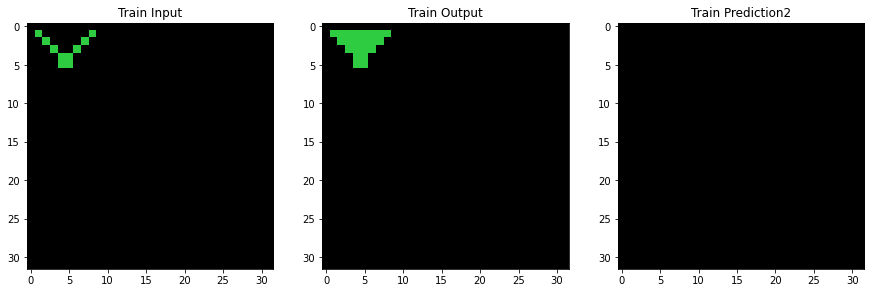

In [84]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(ww, cmap=cmap, norm=norm)
ax[0].set_title('Train Input')
ax[1].imshow(vv, cmap=cmap, norm=norm)
ax[1].set_title('Train Output')
# ax[2].imshow(new_arr[0][:10,:10], cmap=cmap, norm=norm)
# ax[2].set_title('Train Prediction')
ax[2].imshow(arr, cmap=cmap, norm=norm)
ax[2].set_title('Train Prediction2')

## --------------------------------------------------------------------------------------------------------------

In [58]:
len(Xs_train_orig[0])

5

IndexError: list index out of range

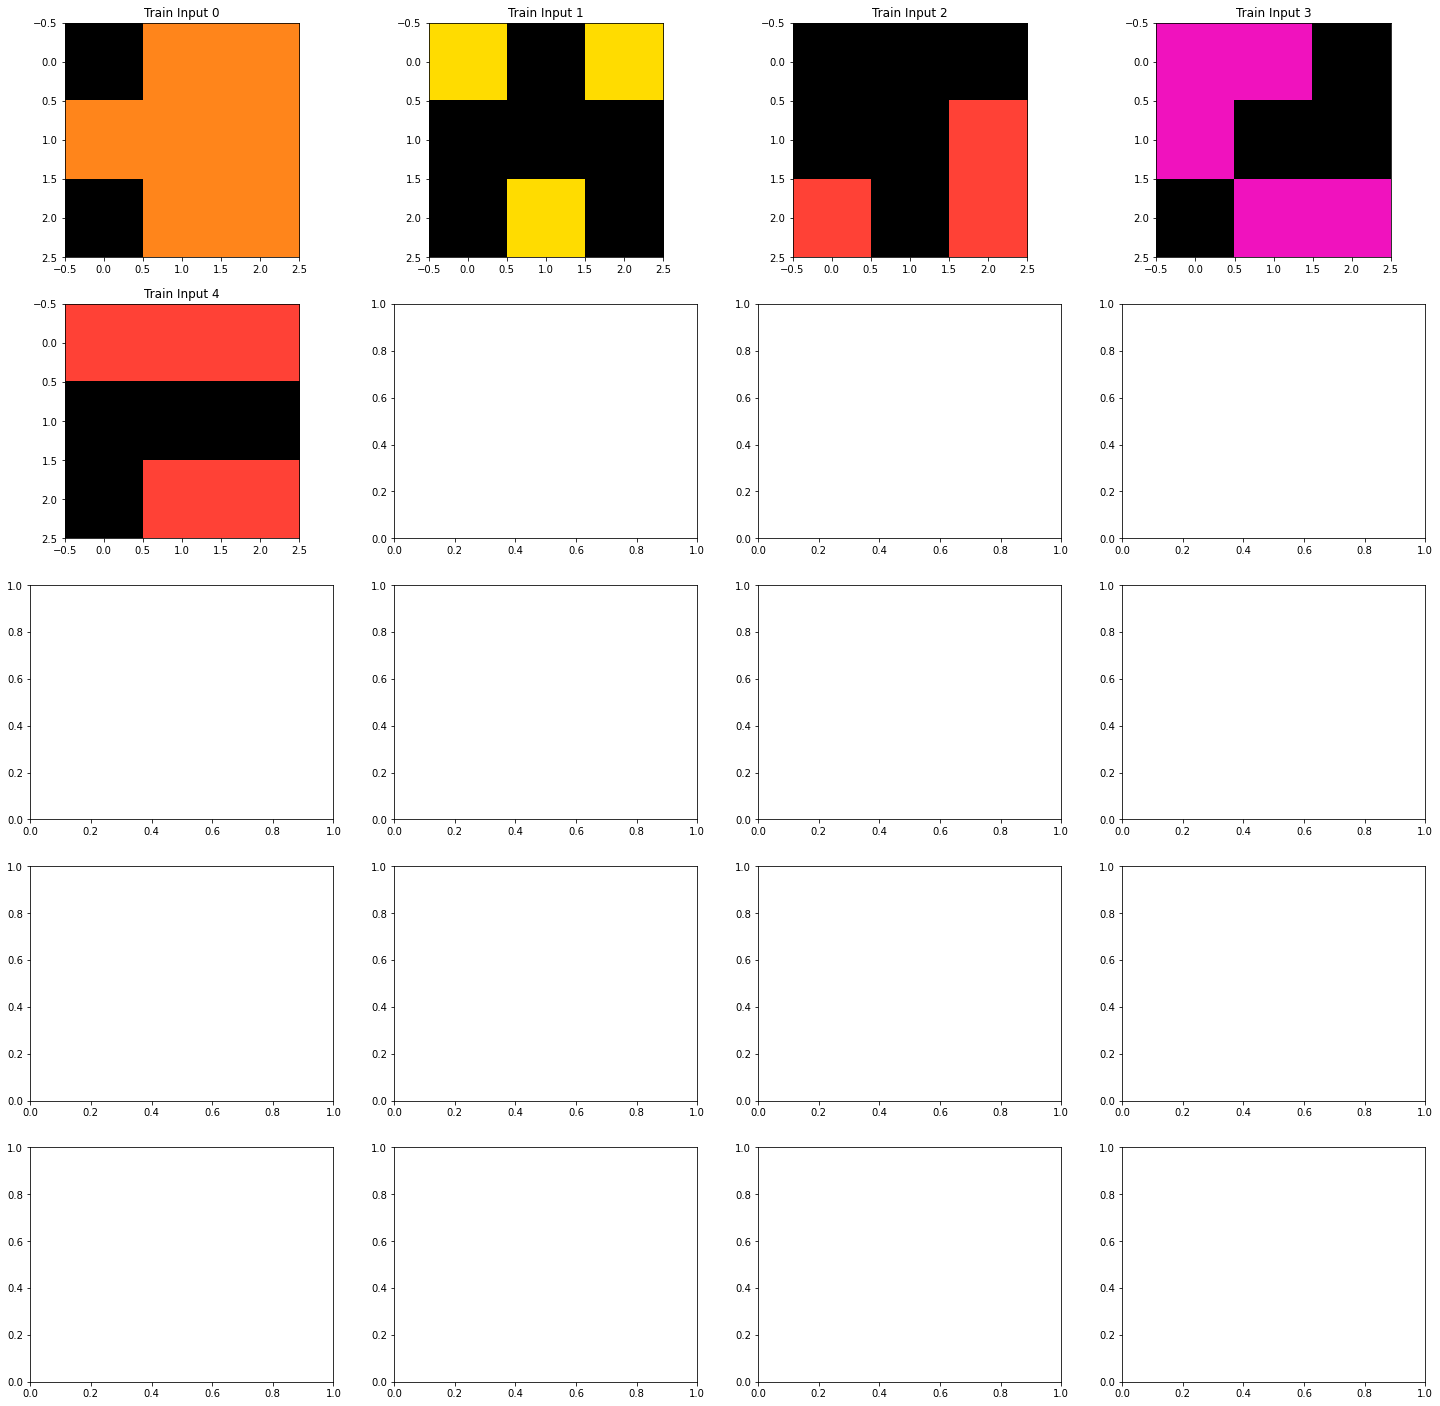

In [59]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(5, 4, figsize=(25,25))
for i in range(5):
    for j in range(4):
        idx = i+j+3*i
        
        ax[i,j].imshow(Xs_train_orig[0][idx], cmap=cmap, norm=norm)
        ax[i,j].set_title(f'Train Input {idx}')

IndexError: index 10 is out of bounds for axis 0 with size 10

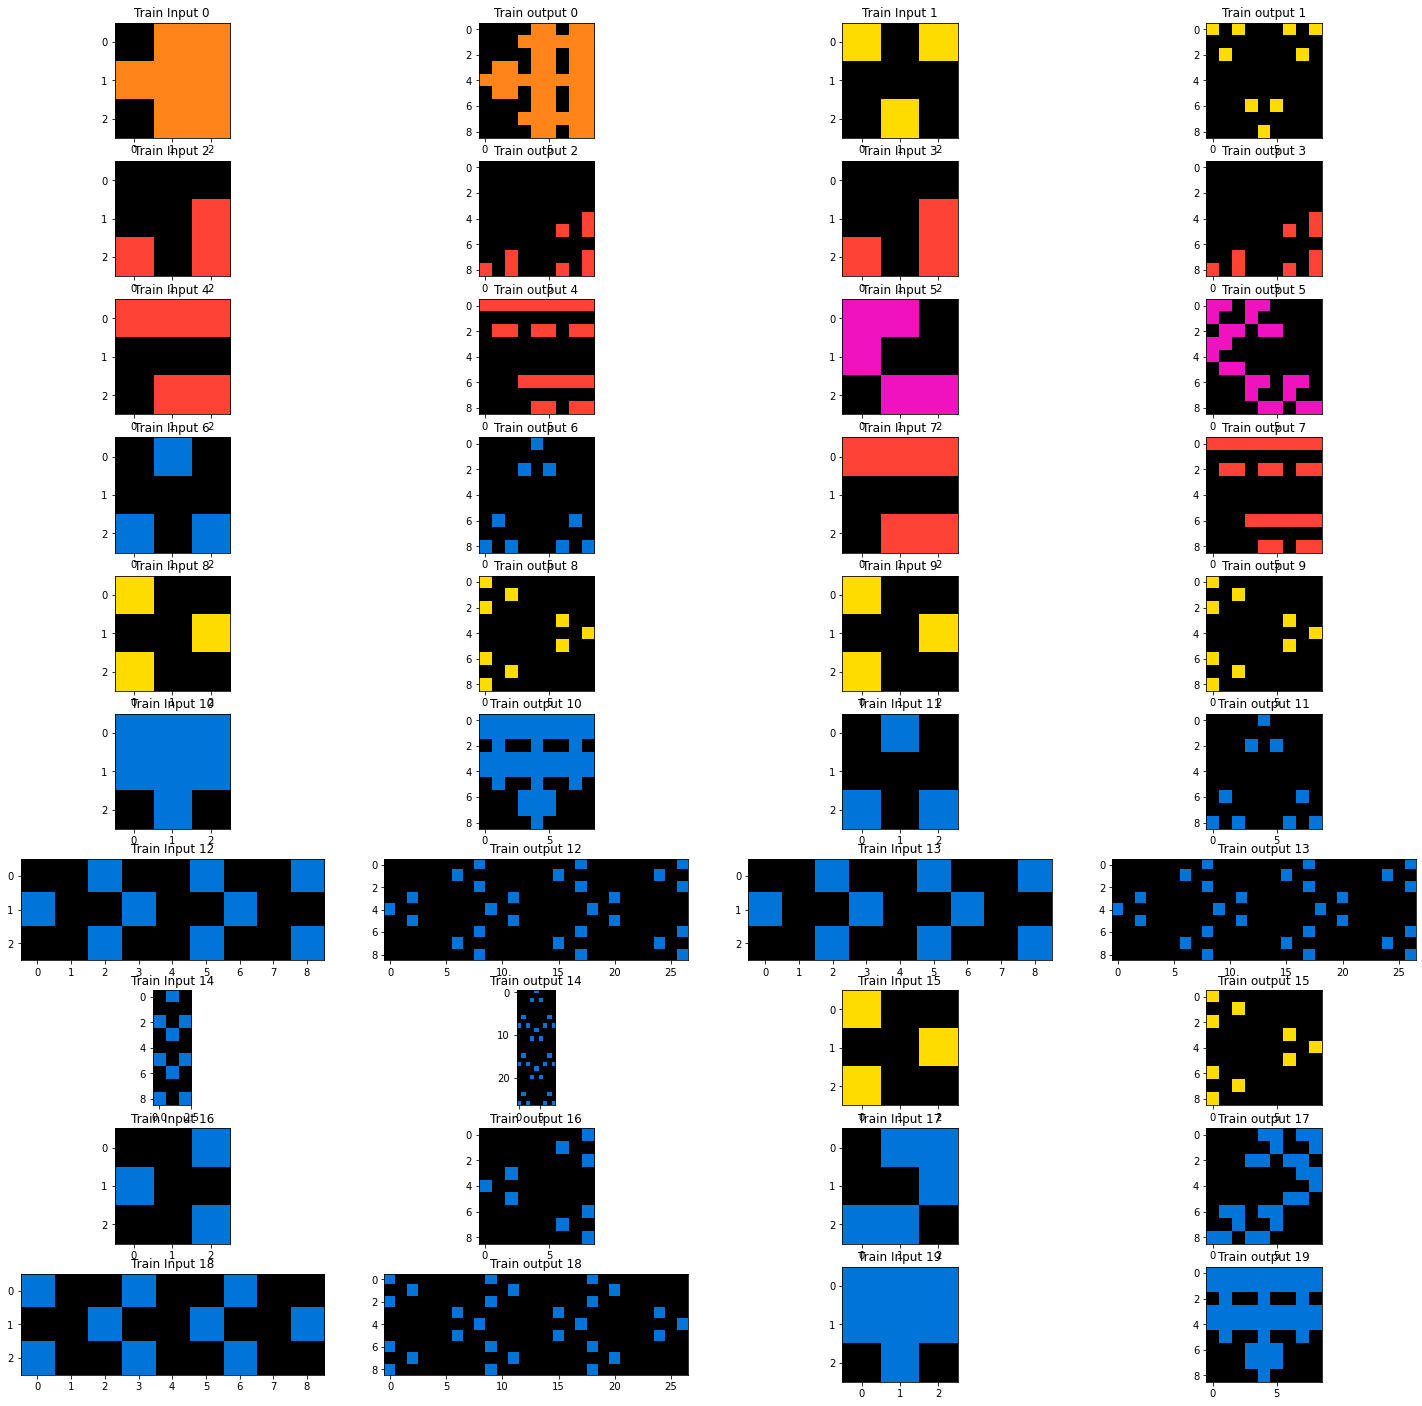

In [76]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(10, 4, figsize=(25,25))
for i in range(20):
        
        ax[i,0].imshow(Xs_train[0][i*2], cmap=cmap, norm=norm)
        ax[i,0].set_title(f'Train Input {i*2}')
        ax[i,1].imshow(ys_train[0][i*2], cmap=cmap, norm=norm)
        ax[i,1].set_title(f'Train output {i*2}')
        ax[i,2].imshow(Xs_train[0][i+1], cmap=cmap, norm=norm)
        ax[i,2].set_title(f'Train Input {i*2+1}')
        ax[i,3].imshow(ys_train[0][i+1], cmap=cmap, norm=norm)
        ax[i,3].set_title(f'Train output {i*2+1}')

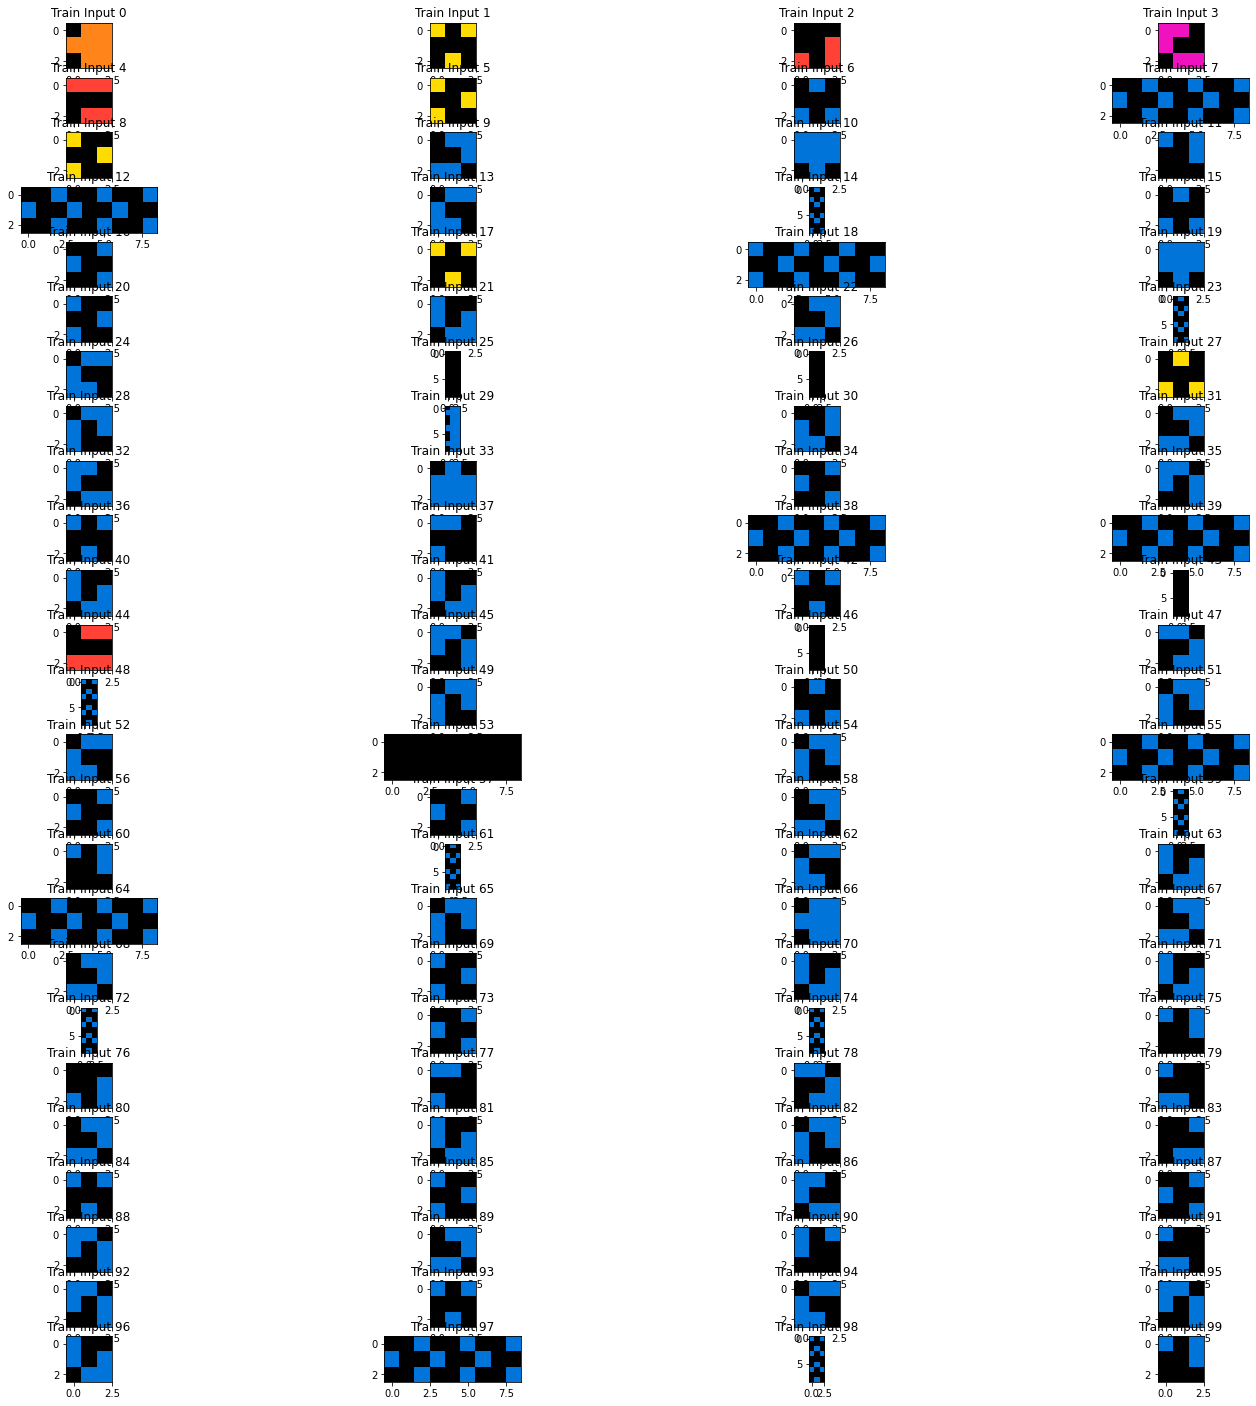

In [86]:
cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
fig, ax = plt.subplots(25, 4, figsize=(25,25))
for i in range(25):
    for j in range(4):
        idx = i+j+3*i
        
        ax[i,j].imshow(Xs_train[0][idx], cmap=cmap, norm=norm)
        ax[i,j].set_title(f'Train Input {idx}')